In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# ghg = pd.read_csv('results/oneshot_hierarchical/flattened_one-shot_phi-4.csv')
# ghg['pred_detection'].unique()

In [3]:
results_dir = 'results'
all_experiments = {}

# loop through folders in results_dir
for folder in os.listdir(results_dir):
    folder_path = os.path.join(results_dir, folder)
    # loop through json files in the folder
    # ignore non-directory files
    if not os.path.isdir(folder_path):
        continue
    print (f'Processing folder: {folder}')
    all_experiments[folder] = []
    for file in os.listdir(folder_path):
        if file.endswith('.json'):
            file_path = os.path.join(folder_path, file)
            print(f'Processing file: {file_path}')

            with open(file_path, 'r') as f:
                data = json.load(f)
                # Assuming data is a list of dictionaries
                df = pd.DataFrame([data])
                all_experiments[folder].append(df)               # or save the plot using plt.savefig()

Processing folder: oneshot_fixed
Processing file: results\oneshot_fixed\evaluation_results_one-shot_llama-instruct.json
Processing file: results\oneshot_fixed\evaluation_results_one-shot_llama.json
Processing file: results\oneshot_fixed\evaluation_results_one-shot_menda.json
Processing file: results\oneshot_fixed\evaluation_results_one-shot_mistralai.json
Processing file: results\oneshot_fixed\evaluation_results_one-shot_phi-4.json
Processing file: results\oneshot_fixed\evaluation_results_one-shot_tinyllama.json
Processing folder: oneshot_flattened
Processing file: results\oneshot_flattened\evaluation_results_flattened_one-shot_llama-instruct.json
Processing file: results\oneshot_flattened\evaluation_results_flattened_one-shot_llama.json
Processing file: results\oneshot_flattened\evaluation_results_flattened_one-shot_menda.json
Processing file: results\oneshot_flattened\evaluation_results_flattened_one-shot_mistralai.json
Processing file: results\oneshot_flattened\evaluation_results_fl

In [4]:
all_experiments.keys()

dict_keys(['oneshot_fixed', 'oneshot_flattened', 'oneshot_hierarchical', 'oneshot_simple', 'zeroshot_fixed', 'zeroshot_flattened', 'zeroshot_hierarchical', 'zeroshot_simple'])

In [5]:
# remove all "simple" entries
for key in list(all_experiments.keys()):
    if 'simple' in key:
        del all_experiments[key]

#rename all 'fixed' entries to 'all at once'
for key in list(all_experiments.keys()):
    if 'fixed' in key:
        new_key = key.replace('fixed', 'all at once')
        all_experiments[new_key] = all_experiments[key]
        del all_experiments[key]

<Figure size 1000x600 with 0 Axes>

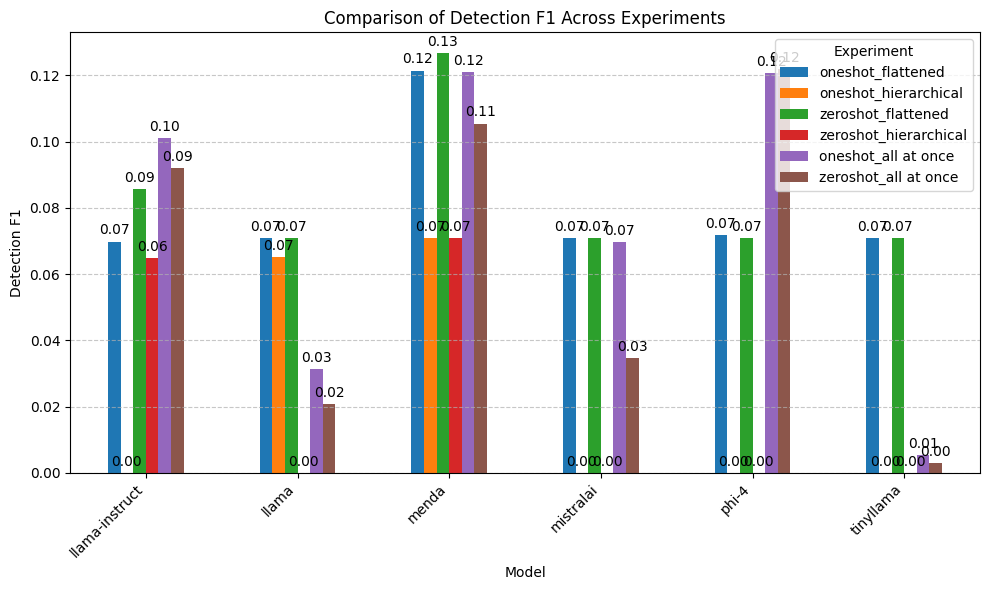

<Figure size 1000x600 with 0 Axes>

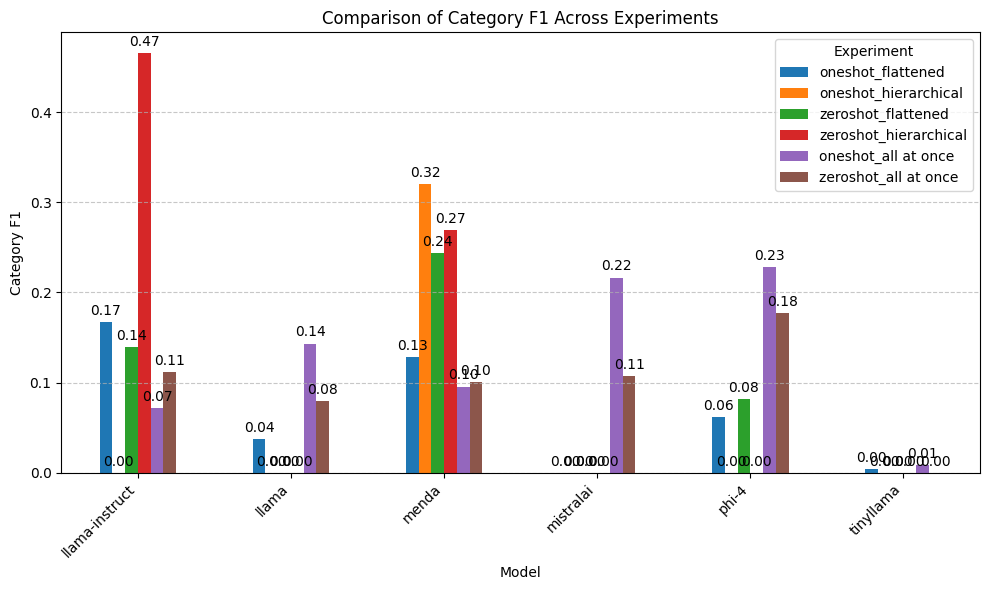

<Figure size 1000x600 with 0 Axes>

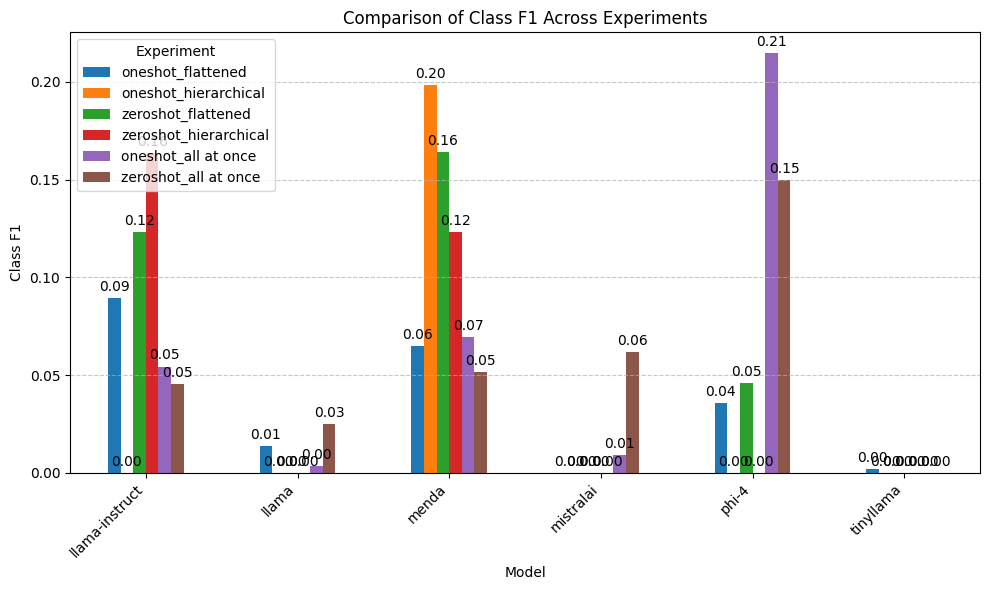

<Figure size 1000x600 with 0 Axes>

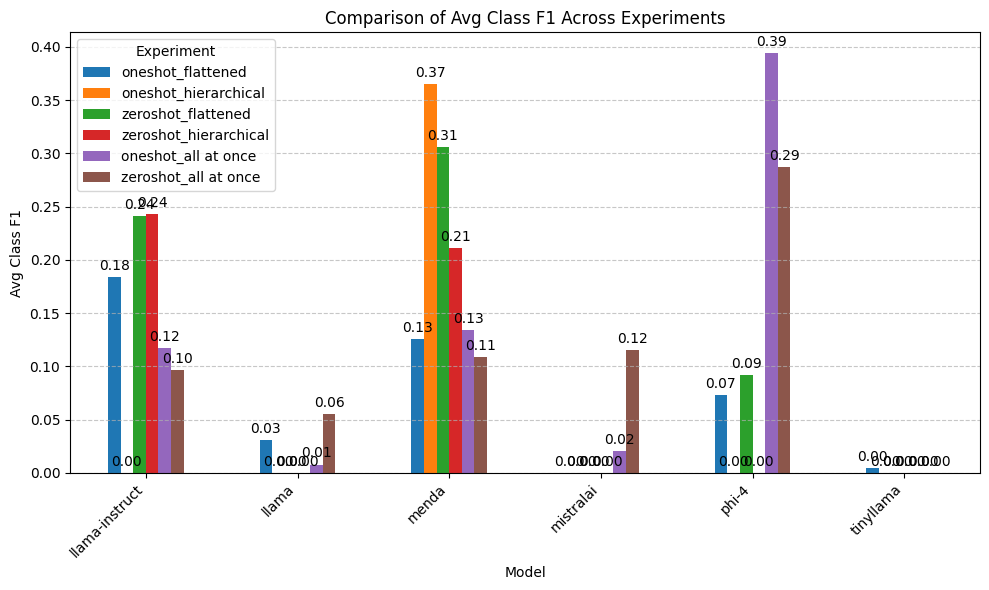

In [6]:
# Create a function to extract and organize the data for plotting
def create_comparison_df(all_experiments, metric):
    """
    Extract a specific metric from all experiments and organize it by model
    
    Parameters:
    all_experiments (dict): Dictionary of experiment results
    metric (str): The metric to compare (e.g., 'detection_accuracy')
    
    Returns:
    pd.DataFrame: DataFrame with models as rows and experiments as columns
    """
    comparison_data = {}
    
    for experiment_name, experiment_dfs in all_experiments.items():
        for df in experiment_dfs:
            model_name = df['model_name'].values[0]
            metric_value = df[metric].values[0]
            
            if model_name not in comparison_data:
                comparison_data[model_name] = {}
            
            comparison_data[model_name][experiment_name] = metric_value
    
    return pd.DataFrame.from_dict(comparison_data, orient='index')

# Define a function to plot the comparison
def plot_metric_comparison(all_experiments, metric, title=None, figsize=(10, 6)):
    """
    Plot a comparison of a specific metric across different experiments
    
    Parameters:
    all_experiments (dict): Dictionary of experiment results
    metric (str): The metric to compare (e.g., 'detection_accuracy')
    title (str, optional): Title for the plot
    figsize (tuple, optional): Figure size
    """
    comparison_df = create_comparison_df(all_experiments, metric)
    
    # Plot the data
    plt.figure(figsize=figsize)
    ax = comparison_df.plot(kind='bar', figsize=figsize)
    
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel(metric.replace('_', ' ').title())
    
    if title:
        plt.title(title)
    else:
        plt.title(f'Comparison of {metric.replace("_", " ").title()} Across Experiments')
    
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Experiment')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)
    
    plt.tight_layout()
    return plt

# Example usage for detection accuracy
# metric_to_plot = 'detection_accuracy'
# plot = plot_metric_comparison(all_experiments, metric_to_plot)
# plt.show()

# You can also plot other metrics
metrics = ['detection_f1', 'category_f1', 'class_f1', 'avg_class_f1']
for metric in metrics:
    plot_metric_comparison(all_experiments, metric)
    # plt.savefig(f'{metric}_comparison.png')
    plt.show()

<Figure size 1200x600 with 0 Axes>

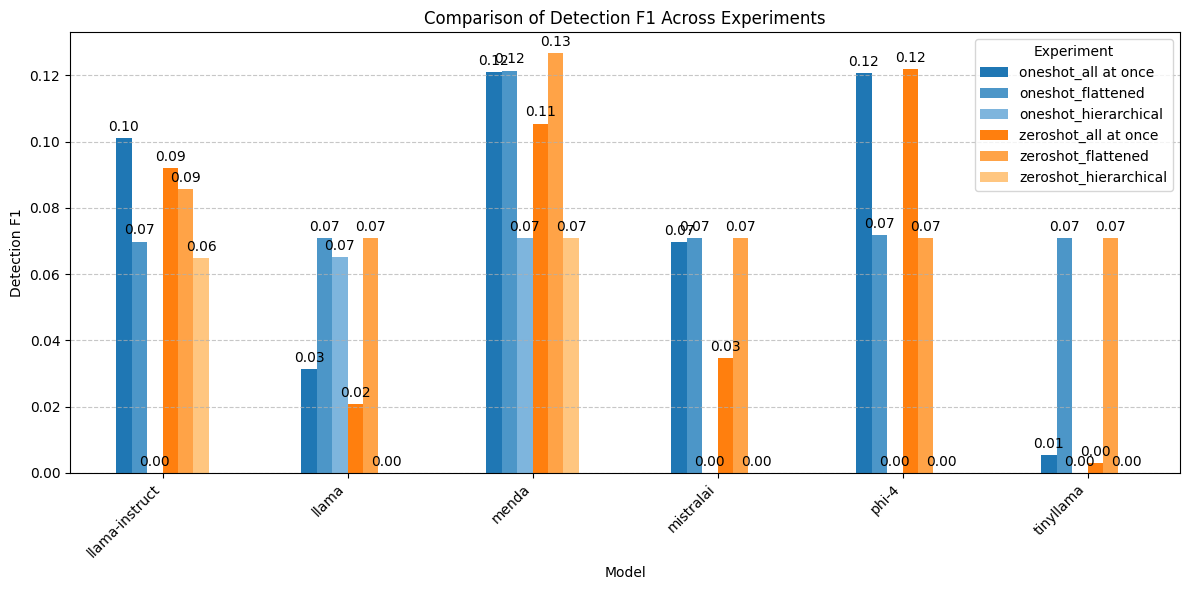

<Figure size 1200x600 with 0 Axes>

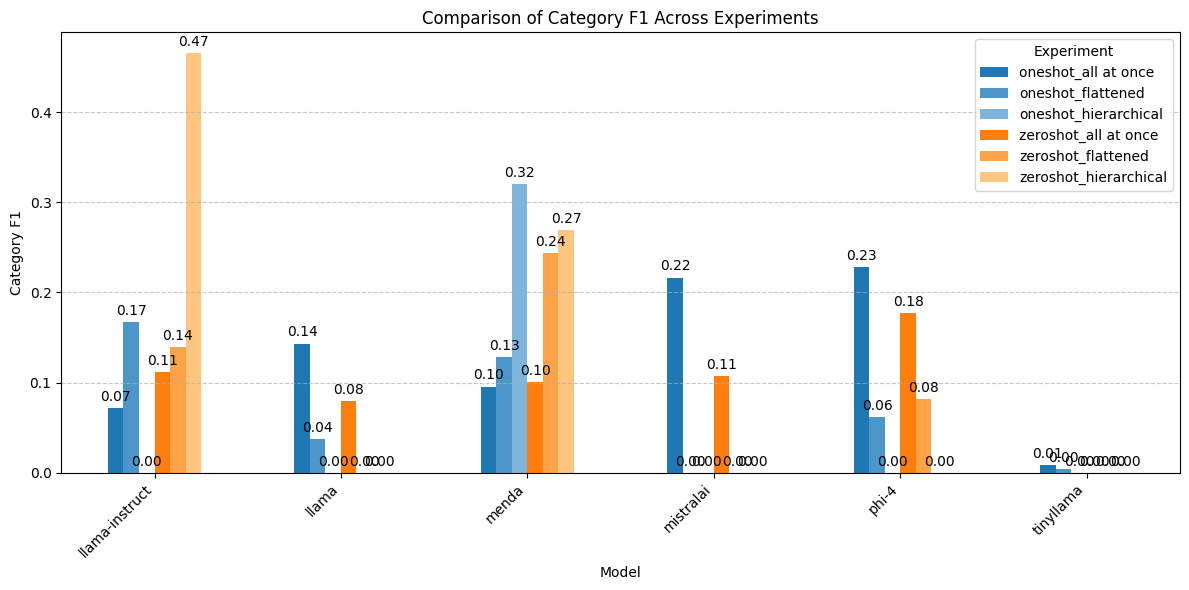

<Figure size 1200x600 with 0 Axes>

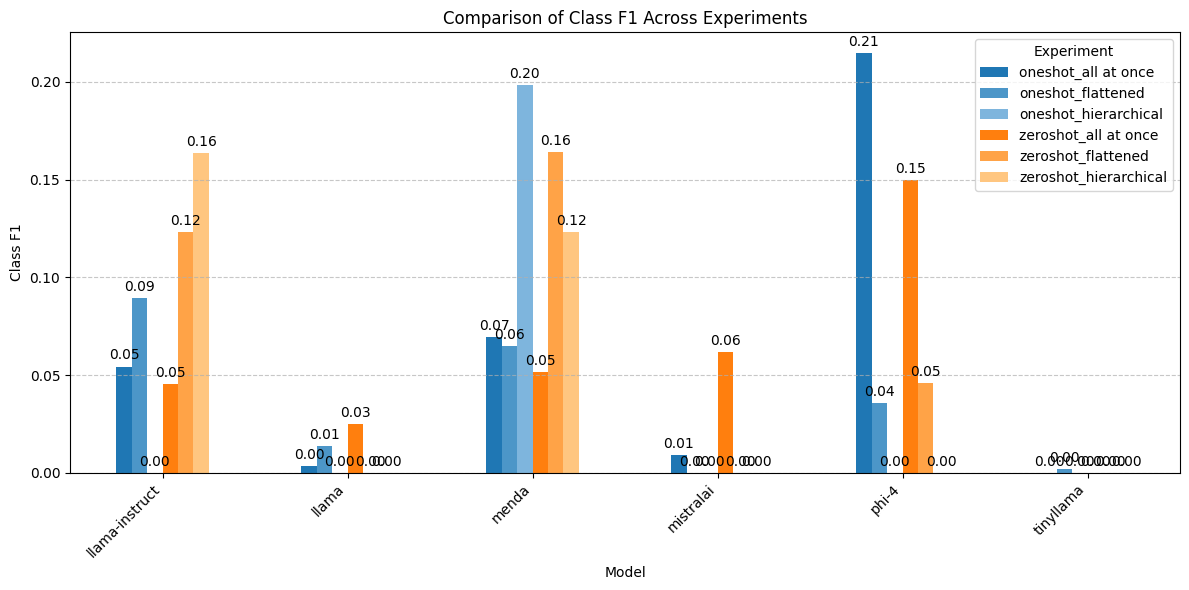

<Figure size 1200x600 with 0 Axes>

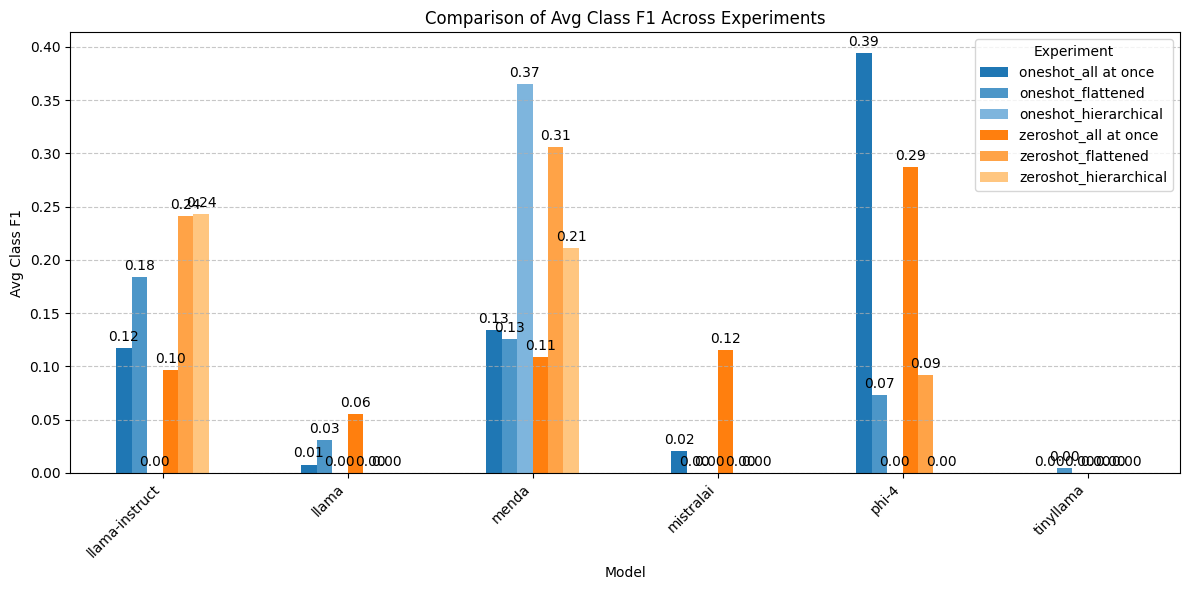

In [7]:
def plot_metric_comparison(all_experiments, metric, title=None, figsize=(12, 6)):
    """
    Plot a comparison of a specific metric across different experiments
    with oneshot and zeroshot bars grouped by similar colors
    """
    comparison_df = create_comparison_df(all_experiments, metric)
    
    # Reorder columns to group oneshot and zeroshot experiments together
    ordered_columns = sorted(comparison_df.columns, 
                            key=lambda x: ('1' if 'oneshot' in x else '2') + x)
    comparison_df = comparison_df[ordered_columns]
    
    # Create a custom color palette with different shades
    colors = []
    blue_shades = ['#1f77b4', '#4c96c8', '#7eb5dd', '#abd4f1']  # Different blues
    orange_shades = ['#ff7f0e', '#ffa347', '#ffc680', '#ffe9c8']  # Different oranges
    
    blue_idx = 0
    orange_idx = 0
    
    for col in ordered_columns:
        if 'oneshot' in col:
            colors.append(blue_shades[blue_idx % len(blue_shades)])
            blue_idx += 1
        else:  # zeroshot
            colors.append(orange_shades[orange_idx % len(orange_shades)])
            orange_idx += 1
    
    # Plot the data with custom colors
    plt.figure(figsize=figsize)
    ax = comparison_df.plot(kind='bar', figsize=figsize, color=colors)
    
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel(metric.replace('_', ' ').title())
    
    if title:
        plt.title(title)
    else:
        plt.title(f'Comparison of {metric.replace("_", " ").title()} Across Experiments')
    
    plt.xticks(rotation=45, ha='right')
    
    # Use regular legend with all experiment names
    plt.legend(title='Experiment', loc='best')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)
    
    plt.tight_layout()
    return plt

# You can also plot other metrics
metrics = ['detection_f1', 'category_f1', 'class_f1', 'avg_class_f1']
for metric in metrics:
    plot_metric_comparison(all_experiments, metric)
    # plt.savefig(f'{metric}_comparison.png')
    plt.show()

<Figure size 1200x600 with 0 Axes>

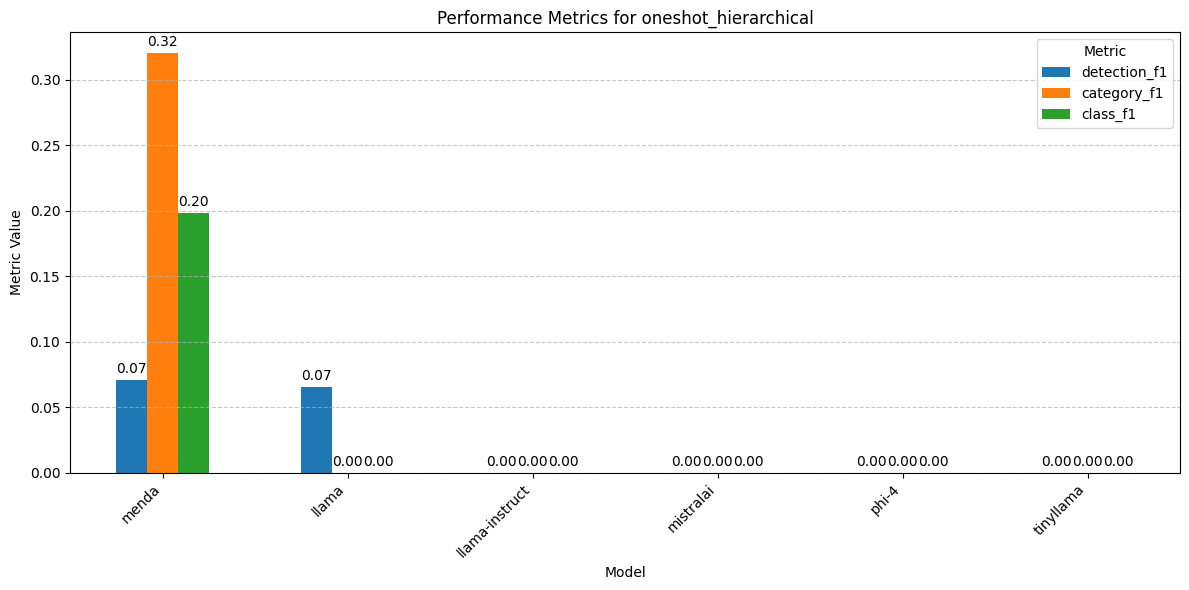

<Figure size 1200x600 with 0 Axes>

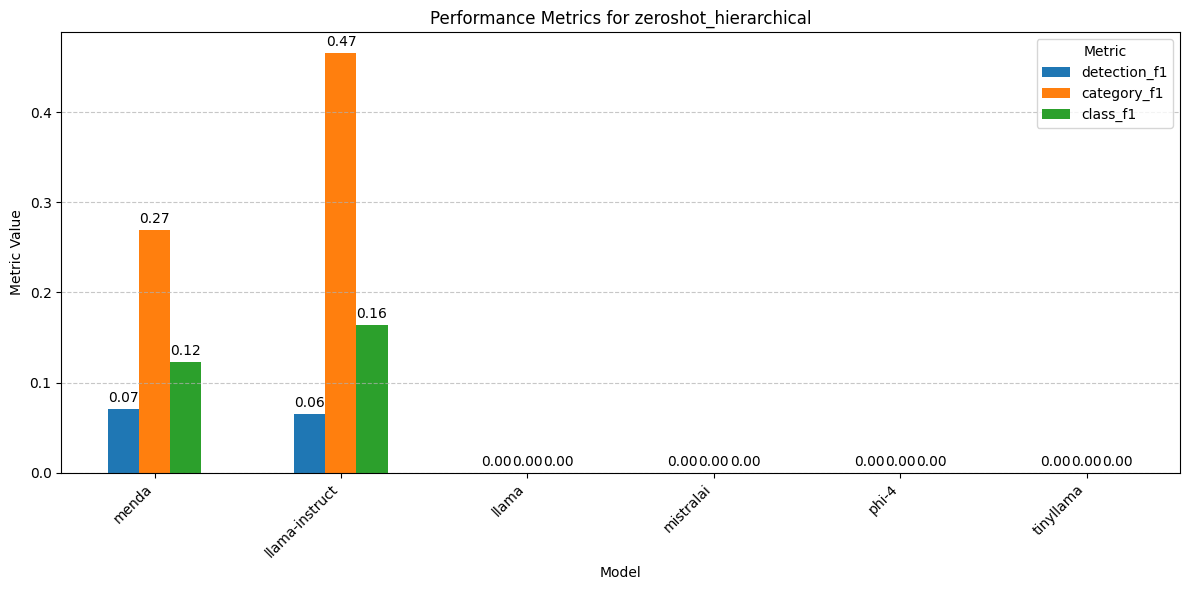

In [8]:
def plot_single_experiment_metrics(all_experiments, experiment_name, metrics=None, figsize=(12, 6)):
    """
    Plot multiple metrics for a single experiment type
    
    Parameters:
    all_experiments (dict): Dictionary of experiment results
    experiment_name (str): Name of the experiment to plot (e.g., 'oneshot_flattened')
    metrics (list, optional): List of metrics to plot. If None, uses default metrics
    figsize (tuple, optional): Figure size
    """
    if metrics is None:
        metrics = ['detection_accuracy', 'category_accuracy', 'class_accuracy', 'avg_class_f1']
    
    # Create data for the selected experiment
    experiment_data = {}
    if experiment_name in all_experiments:
        for df in all_experiments[experiment_name]:
            model_name = df['model_name'].values[0]
            model_data = {}
            for metric in metrics:
                if metric in df.columns:
                    model_data[metric] = df[metric].values[0]
            experiment_data[model_name] = model_data
    
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(experiment_data, orient='index')
    
    # Sort by the first metric to get a reasonable order
    if not df.empty and metrics[0] in df.columns:
        df = df.sort_values(by=metrics[0], ascending=False)
    
    # Create plot
    plt.figure(figsize=figsize)
    ax = df.plot(kind='bar', figsize=figsize)
    
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel('Metric Value')
    plt.title(f'Performance Metrics for {experiment_name}')
    
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metric')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)
    
    plt.tight_layout()
    return plt

# Example usage:
experiment_to_plot = 'oneshot_hierarchical'
plot_single_experiment_metrics(all_experiments, experiment_to_plot, metrics = ['detection_f1', 'category_f1', 'class_f1'])
plt.show()

experiment_to_plot = 'zeroshot_hierarchical'
plot_single_experiment_metrics(all_experiments, experiment_to_plot, metrics = ['detection_f1', 'category_f1', 'class_f1'])
plt.show()

# Or if you want to compare just specific metrics:
# custom_metrics = ['detection_accuracy', 'avg_class_f1']
# plot_single_experiment_metrics(all_experiments, experiment_to_plot, metrics=custom_metrics)
# plt.show()

<Figure size 1000x600 with 0 Axes>

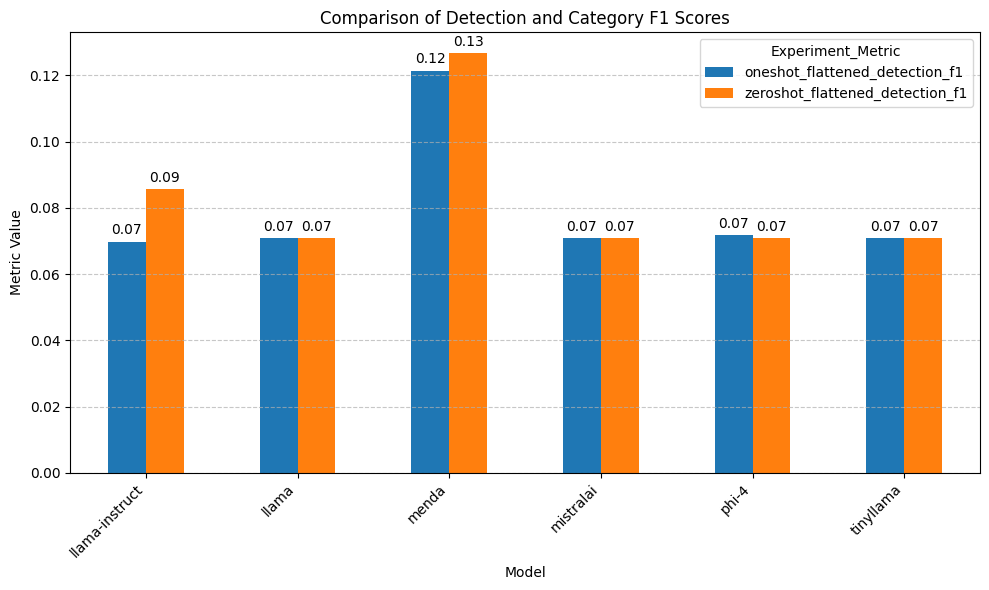

In [9]:
def plot_filtered_comparison(all_experiments, experiment_names, metric_names, title=None, figsize=(10, 6)):
    """
    Plot a comparison of specific metrics across selected experiments
    
    Parameters:
    all_experiments (dict): Dictionary of experiment results
    experiment_names (list): List of experiment names to include in the plot
    metric_names (list): List of metric names to include in the plot
    title (str, optional): Title for the plot
    figsize (tuple, optional): Figure size
    
    Returns:
    matplotlib.pyplot: The plot object
    """
    # Filter experiments to only include those in experiment_names
    filtered_experiments = {name: all_experiments[name] for name in experiment_names if name in all_experiments}
    
    # Create a dictionary to store the data organized by model and metric
    model_data = {}
    
    # Extract data for each model, experiment, and metric
    for exp_name, exp_dfs in filtered_experiments.items():
        for df in exp_dfs:
            model_name = df['model_name'].values[0]
            
            if model_name not in model_data:
                model_data[model_name] = {}
            
            for metric in metric_names:
                if metric in df.columns:
                    column_name = f"{exp_name}_{metric}"
                    model_data[model_name][column_name] = df[metric].values[0]
    
    # Convert to DataFrame
    result_df = pd.DataFrame.from_dict(model_data, orient='index')
    
    # The error is in this sorting function - let's fix it
    # We need to extract the metric name correctly from the column name
    
    # First define a function to get the metric index
    def get_metric_index(col_name):
        # Find which metric is in the column name
        for i, metric in enumerate(metric_names):
            if metric in col_name:
                return i
        return 0
    
    # Sort columns to group by metric
    ordered_columns = sorted(result_df.columns, key=get_metric_index)
    result_df = result_df[ordered_columns]
    
    # Create a custom color palette
    colors = []
    blue_shades = ['#1f77b4', '#4c96c8', '#7eb5dd', '#abd4f1']  # Different blues
    orange_shades = ['#ff7f0e', '#ffa347', '#ffc680', '#ffe9c8']  # Different oranges
    
    # Assign colors based on experiment type (oneshot vs zeroshot)
    for col in ordered_columns:
        if 'oneshot' in col:
            # Use a shade of blue based on which metric it is
            metric_idx = get_metric_index(col)
            colors.append(blue_shades[metric_idx % len(blue_shades)])
        else:  # zeroshot
            # Use a shade of orange based on which metric it is
            metric_idx = get_metric_index(col)
            colors.append(orange_shades[metric_idx % len(orange_shades)])
    
    # Create plot
    plt.figure(figsize=figsize)
    ax = result_df.plot(kind='bar', figsize=figsize, color=colors)
    
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel('Metric Value')
    
    if title:
        plt.title(title)
    else:
        plt.title(f'Comparison of Selected Metrics Across Selected Experiments')
    
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Experiment_Metric', loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)
    
    plt.tight_layout()
    return plt

# Example usage:
experiments_to_compare = ['oneshot_flattened', 'zeroshot_flattened']
metrics_to_compare = ['detection_f1']

plot_filtered_comparison(
    all_experiments, 
    experiments_to_compare, 
    metrics_to_compare, 
    title="Comparison of Detection and Category F1 Scores"
)
plt.show()

<Figure size 1000x600 with 0 Axes>

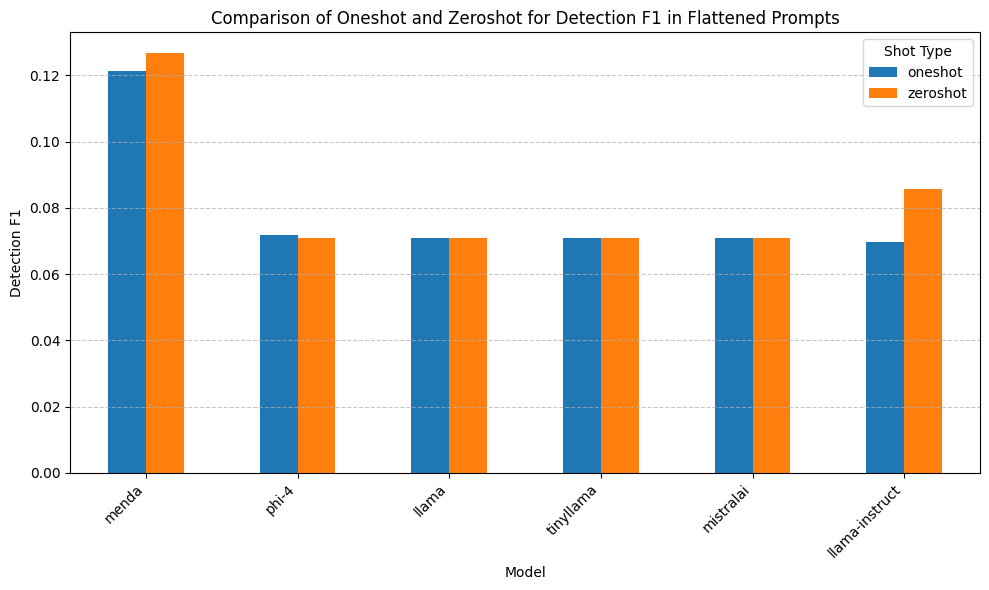

<Figure size 1000x600 with 0 Axes>

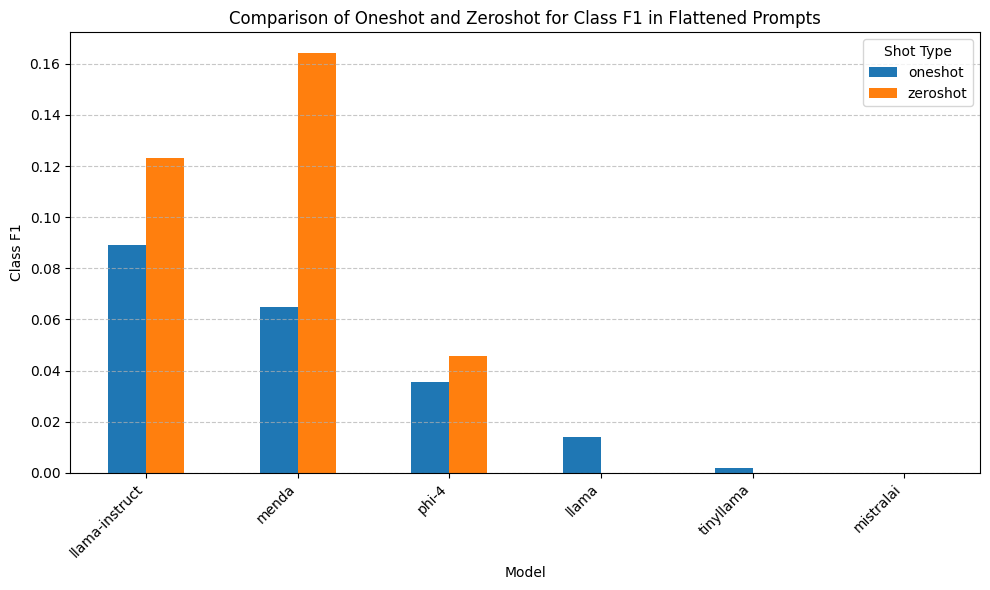

In [ ]:
def plot_experiment_comparison(all_experiments, experiment_base, metric, 
                               show_difference=False, title=None, figsize=(10, 6)):
    """
    Plot oneshot and zeroshot results for a single experiment and metric
    
    Parameters:
    all_experiments (dict): Dictionary of experiment results
    experiment_base (str): Base name of the experiment (without 'oneshot_' or 'zeroshot_' prefix)
    metric (str): The metric to compare (e.g., 'detection_f1')
    show_difference (bool): If True, plot the difference (oneshot - zeroshot) instead of raw values
    title (str, optional): Title for the plot
    figsize (tuple, optional): Figure size
    
    Returns:
    matplotlib.pyplot: The plot object
    """
    oneshot_name = f"oneshot_{experiment_base}"
    zeroshot_name = f"zeroshot_{experiment_base}"
    
    # Check if both experiment versions exist
    if oneshot_name not in all_experiments or zeroshot_name not in all_experiments:
        print(f"Missing experiment data: oneshot={oneshot_name in all_experiments}, zeroshot={zeroshot_name in all_experiments}")
        return None
    
    # Get the oneshot data
    oneshot_data = {}
    for df in all_experiments[oneshot_name]:
        model_name = df['model_name'].values[0]
        if metric in df.columns:
            oneshot_data[model_name] = df[metric].values[0]
    
    # Get the zeroshot data
    zeroshot_data = {}
    for df in all_experiments[zeroshot_name]:
        model_name = df['model_name'].values[0]
        if metric in df.columns:
            zeroshot_data[model_name] = df[metric].values[0]
    
    # Find common models
    common_models = set(oneshot_data.keys()).intersection(set(zeroshot_data.keys()))
    
    # Prepare data for plotting
    if show_difference:
        # Calculate difference (oneshot - zeroshot)
        data = {model: {'difference': oneshot_data[model] - zeroshot_data[model]} 
                for model in common_models}
        df = pd.DataFrame.from_dict(data, orient='index')
        
        # Sort by difference value
        df = df.sort_values(by='difference', ascending=False)
        
        # Create plot with a single color
        plt.figure(figsize=figsize)
        ax = df.plot(kind='bar', figsize=figsize, color='#2ca02c', legend=False)
        
        # Add a horizontal line at y=0
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # Labels
        plt.xlabel('Model')
        plt.ylabel(f'Difference in {metric.replace("_", " ").title()} (Oneshot - Zeroshot)')
        
    else:
        # Prepare raw values for both shot types
        data = {model: {'oneshot': oneshot_data[model], 'zeroshot': zeroshot_data[model]} 
                for model in common_models}
        df = pd.DataFrame.from_dict(data, orient='index')
        
        # Sort by oneshot values
        df = df.sort_values(by='oneshot', ascending=False)
        
        # Create plot with different colors for oneshot and zeroshot
        plt.figure(figsize=figsize)
        ax = df.plot(kind='bar', figsize=figsize, 
                    color={'oneshot': '#1f77b4', 'zeroshot': '#ff7f0e'})
        
        # Labels
        plt.xlabel('Model')
        plt.ylabel(f'{metric.replace("_", " ").title()}')
    
    # Set title
    if title:
        plt.title(title)
    else:
        if experiment_base == 'fixed':
            experiment_base = 'All At Once'
        # capitalize first letter in the metric name and experiment base
        experiment_base = experiment_base.replace('_', ' ').title()
        metric = metric.replace('_', ' ').title()

        if show_difference:
            plt.title(f'Difference Between Oneshot and Zeroshot for {metric.replace("_", " ").title()} in {experiment_base} Prompts')
        else:
            plt.title(f'Comparison of Oneshot and Zeroshot for {metric.replace("_", " ").title()} in {experiment_base} Prompts')
    
    plt.xticks(rotation=45, ha='right')
    if not show_difference:
        plt.legend(title='Shot Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for container in ax.containers:
        if show_difference:
            ax.bar_label(container, fmt='%.2f', padding=3)
    
    # set background color to #c3d5fe
    plt.gcf().set_facecolor('white')
    # set background colour ot actual plot area to white
    ax.set_facecolor('white')
        
    plt.tight_layout()
    return plt

# Example usage:
metric_to_plot = 'detection_f1'
experiment_to_plot = 'flattened'

# Plot raw values
plot_experiment_comparison(
    all_experiments,
    experiment_to_plot,
    metric_to_plot,
    show_difference=False
)
plt.show()

metric_to_plot = 'class_f1'

# Plot raw values
plot_experiment_comparison(
    all_experiments,
    experiment_to_plot,
    metric_to_plot,
    show_difference=False
)
plt.show()

<Figure size 1000x600 with 0 Axes>

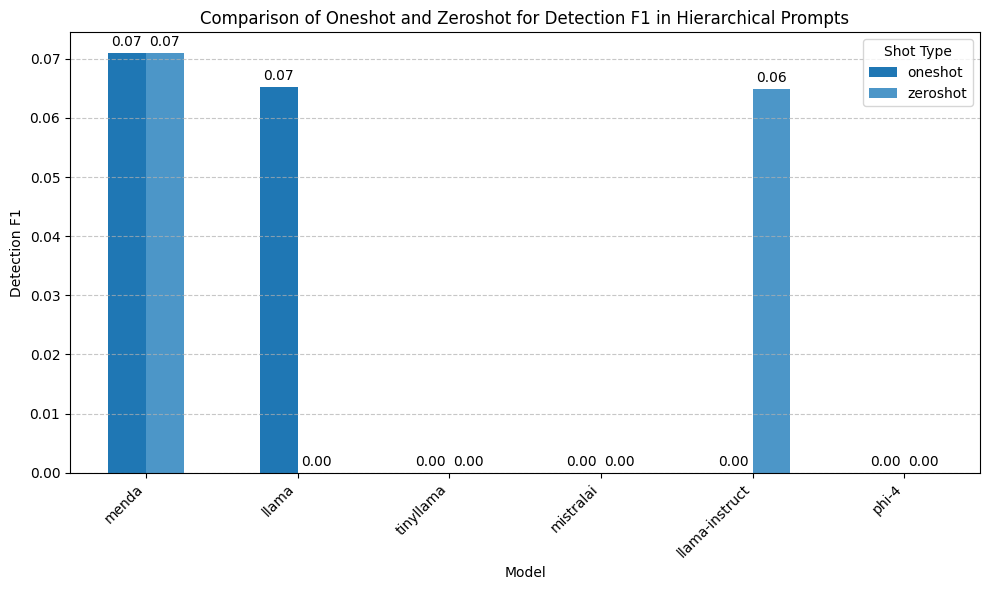

<Figure size 1000x600 with 0 Axes>

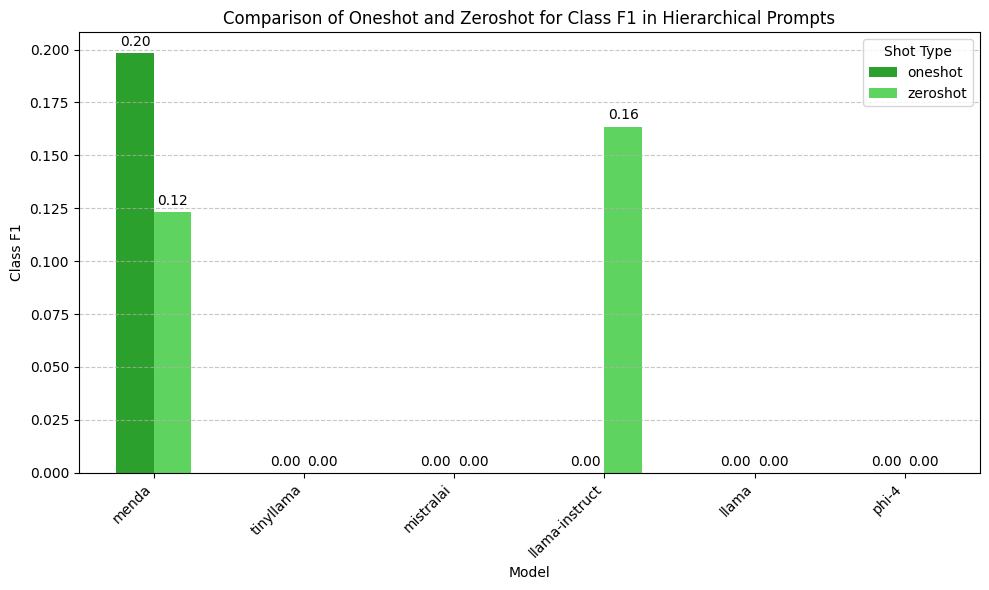

<Figure size 1000x600 with 0 Axes>

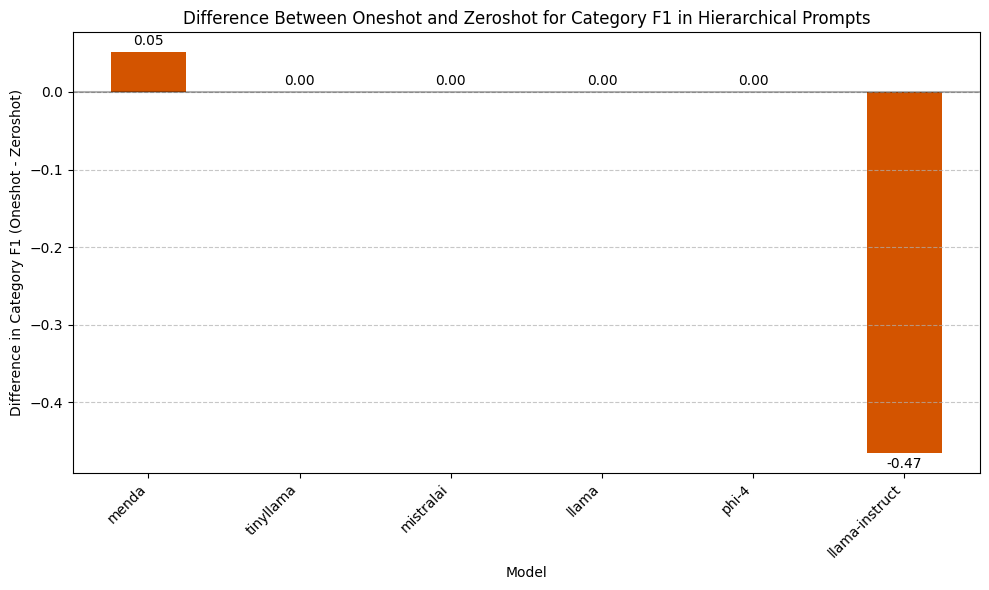

In [19]:
def plot_experiment_comparison(all_experiments, experiment_base, metric, 
                               show_difference=False, title=None, figsize=(10, 6)):
    """
    Plot oneshot and zeroshot results for a single experiment and metric
    
    Parameters:
    all_experiments (dict): Dictionary of experiment results
    experiment_base (str): Base name of the experiment (without 'oneshot_' or 'zeroshot_' prefix)
    metric (str): The metric to compare (e.g., 'detection_f1')
    show_difference (bool): If True, plot the difference (oneshot - zeroshot) instead of raw values
    title (str, optional): Title for the plot
    figsize (tuple, optional): Figure size
    
    Returns:
    matplotlib.pyplot: The plot object
    """
    oneshot_name = f"oneshot_{experiment_base}"
    zeroshot_name = f"zeroshot_{experiment_base}"
    
    # Check if both experiment versions exist
    if oneshot_name not in all_experiments or zeroshot_name not in all_experiments:
        print(f"Missing experiment data: oneshot={oneshot_name in all_experiments}, zeroshot={zeroshot_name in all_experiments}")
        return None
    
    # Get the oneshot data
    oneshot_data = {}
    for df in all_experiments[oneshot_name]:
        model_name = df['model_name'].values[0]
        if metric in df.columns:
            oneshot_data[model_name] = df[metric].values[0]
    
    # Get the zeroshot data
    zeroshot_data = {}
    for df in all_experiments[zeroshot_name]:
        model_name = df['model_name'].values[0]
        if metric in df.columns:
            zeroshot_data[model_name] = df[metric].values[0]
    
    # Find common models
    common_models = set(oneshot_data.keys()).intersection(set(zeroshot_data.keys()))
    
    # Define color palettes based on the metric
    color_palettes = {
        'detection': {'oneshot': '#1f77b4', 'zeroshot': '#4c96c8', 'difference': '#0d4b76'}, # Blues
        'category': {'oneshot': '#ff7f0e', 'zeroshot': '#ffaf5f', 'difference': '#d35400'},  # Oranges
        'class': {'oneshot': '#2ca02c', 'zeroshot': '#5fd35f', 'difference': '#136d13'},     # Greens
        'accuracy': {'oneshot': '#d62728', 'zeroshot': '#e67677', 'difference': '#a81a1b'},  # Reds
        'f1': {'oneshot': '#9467bd', 'zeroshot': '#b08ad2', 'difference': '#6a3d99'},        # Purples
        'precision': {'oneshot': '#8c564b', 'zeroshot': '#b38276', 'difference': '#5f3b33'}, # Browns
        'recall': {'oneshot': '#e377c2', 'zeroshot': '#edaad9', 'difference': '#c1428f'}     # Pinks
    }
    
    # Select the appropriate color palette
    color_key = next((k for k in color_palettes.keys() if k in metric), 'f1')
    color_palette = color_palettes[color_key]
    
    # Prepare data for plotting
    if show_difference:
        # Calculate difference (oneshot - zeroshot)
        data = {model: {'difference': oneshot_data[model] - zeroshot_data[model]} 
                for model in common_models}
        df = pd.DataFrame.from_dict(data, orient='index')
        
        # Sort by difference value
        df = df.sort_values(by='difference', ascending=False)
        
        # Create plot with color based on metric
        plt.figure(figsize=figsize)
        ax = df.plot(kind='bar', figsize=figsize, color=color_palette['difference'], legend=False)
        
        # Add a horizontal line at y=0
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # Labels
        plt.xlabel('Model')
        plt.ylabel(f'Difference in {metric.replace("_", " ").title()} (Oneshot - Zeroshot)')
        
    else:
        # Prepare raw values for both shot types
        data = {model: {'oneshot': oneshot_data[model], 'zeroshot': zeroshot_data[model]} 
                for model in common_models}
        df = pd.DataFrame.from_dict(data, orient='index')
        
        # Sort by oneshot values
        df = df.sort_values(by='oneshot', ascending=False)
        
        # Create plot with colors based on metric
        plt.figure(figsize=figsize)
        ax = df.plot(kind='bar', figsize=figsize, 
                    color={'oneshot': color_palette['oneshot'], 'zeroshot': color_palette['zeroshot']})
        
        # Labels
        plt.xlabel('Model')
        plt.ylabel(f'{metric.replace("_", " ").title()}')
    
    # Set title
    if title:
        plt.title(title)
    else:
        if experiment_base == 'fixed':
            experiment_base = 'All At Once'
        # capitalize first letter in the metric name and experiment base
        experiment_base = experiment_base.replace('_', ' ').title()
        metric_display = metric.replace('_', ' ').title()

        if show_difference:
            plt.title(f'Difference Between Oneshot and Zeroshot for {metric_display} in {experiment_base} Prompts')
        else:
            plt.title(f'Comparison of Oneshot and Zeroshot for {metric_display} in {experiment_base} Prompts')
    
    plt.xticks(rotation=45, ha='right')
    if not show_difference:
        plt.legend(title='Shot Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for container in ax.containers:
        if show_difference:
            ax.bar_label(container, fmt='%.2f', padding=3)
        else:
            ax.bar_label(container, fmt='%.2f', padding=3)
    
    # set background color to #c3d5fe
    plt.gcf().set_facecolor('white')
    # set background colour of actual plot area
    ax.set_facecolor('white')
        
    plt.tight_layout()
    return plt

# Example usage:
metric_to_plot = 'detection_f1'
experiment_to_plot = 'hierarchical'

# Plot raw values
plot_experiment_comparison(
    all_experiments,
    experiment_to_plot,
    metric_to_plot,
    show_difference=False
)
plt.show()

metric_to_plot = 'class_f1'

# Plot raw values
plot_experiment_comparison(
    all_experiments,
    experiment_to_plot,
    metric_to_plot,
    show_difference=False
)
plt.show()

# Try with difference values
plot_experiment_comparison(
    all_experiments,
    experiment_to_plot,
    'category_f1',
    show_difference=True
)
plt.show()

<Figure size 1200x800 with 0 Axes>

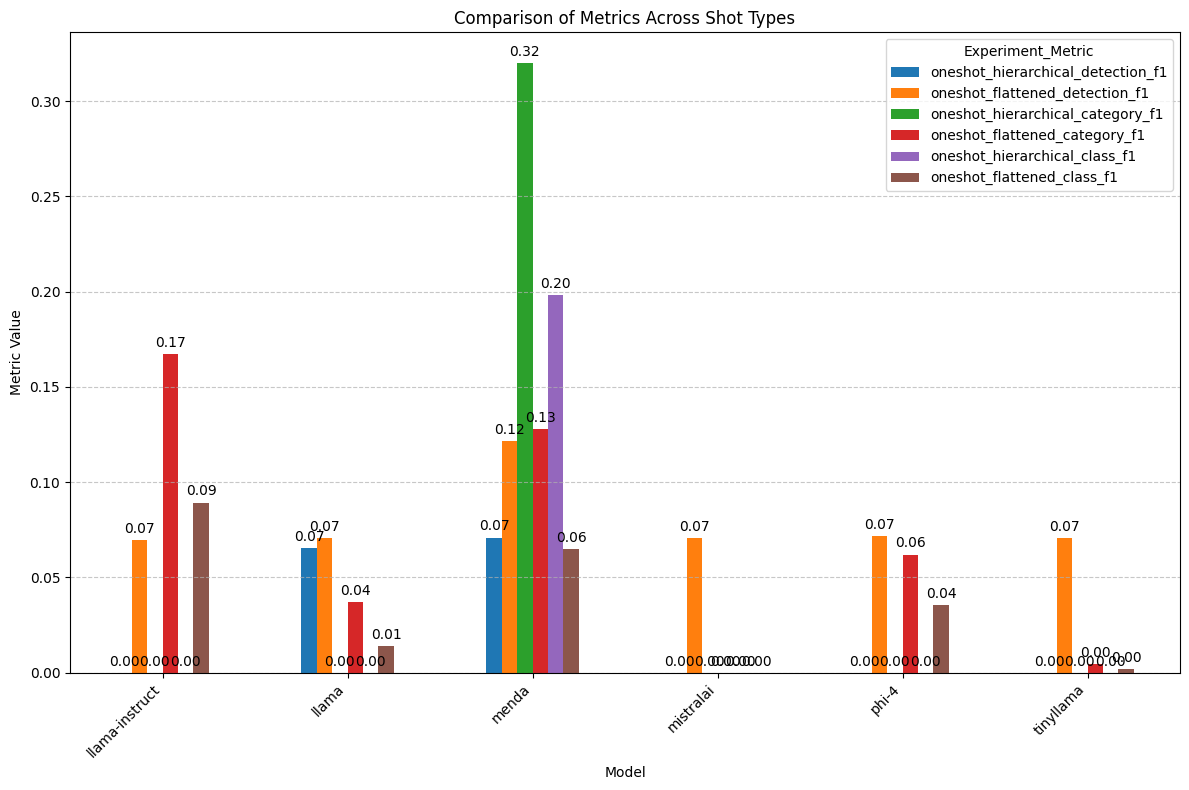

In [12]:
def plot_filtered_comparison(all_experiments, experiment_names, metric_names, title=None, figsize=(12, 8), use_colors=True):
    """
    Plot a comparison of specific metrics across selected experiments
    
    Parameters:
    all_experiments (dict): Dictionary of experiment results
    experiment_names (list): List of experiment names to include in the plot
    metric_names (list): List of metric names to include in the plot
    title (str, optional): Title for the plot
    figsize (tuple, optional): Figure size
    use_colors (bool, optional): Whether to use custom color scheme. Default is True.
    
    Returns:
    matplotlib.pyplot: The plot object
    """
    # Filter experiments to only include those in experiment_names
    filtered_experiments = {name: all_experiments[name] for name in experiment_names if name in all_experiments}
    
    # Create a dictionary to store the data organized by model and metric
    model_data = {}
    
    # Extract data for each model, experiment, and metric
    for exp_name, exp_dfs in filtered_experiments.items():
        for df in exp_dfs:
            model_name = df['model_name'].values[0]
            
            if model_name not in model_data:
                model_data[model_name] = {}
            
            for metric in metric_names:
                if metric in df.columns:
                    column_name = f"{exp_name}_{metric}"
                    model_data[model_name][column_name] = df[metric].values[0]
    
    # Convert to DataFrame
    result_df = pd.DataFrame.from_dict(model_data, orient='index')
    
    # First define a function to get the metric index
    def get_metric_index(col_name):
        # Find which metric is in the column name
        for i, metric in enumerate(metric_names):
            if metric in col_name:
                return i
        return 0
    
    # Sort columns to group by metric
    ordered_columns = sorted(result_df.columns, key=get_metric_index)
    result_df = result_df[ordered_columns]
    
    if use_colors:
        # Create a custom color palette - group by metric
        colors = []
        
        # Define color palette for different metrics
        metric_colors = {
            'detection': ['#1f77b4', '#4c96c8'],  # Blues
            'category': ['#ff7f0e', '#ffa347'],   # Oranges
            'class': ['#2ca02c', '#5fbe5f'],      # Greens
            'avg': ['#d62728', '#e67677']         # Reds
        }
        
        # Assign colors based on metric
        for col in ordered_columns:
            # Determine which metric this column represents
            metric_idx = get_metric_index(col)
            metric = metric_names[metric_idx]
            
            # Find the appropriate color group
            color_key = next((k for k in metric_colors.keys() if k in metric), 'detection')
            
            # Use different shade based on oneshot vs zeroshot
            shade_idx = 0 if 'oneshot' in col else 1
            colors.append(metric_colors[color_key][shade_idx])
        
        # Create plot with custom colors
        plt.figure(figsize=figsize)
        ax = result_df.plot(kind='bar', figsize=figsize, color=colors)
    else:
        # Create plot with default colors
        plt.figure(figsize=figsize)
        ax = result_df.plot(kind='bar', figsize=figsize)
    
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel('Metric Value')
    
    if title:
        plt.title(title)
    else:
        plt.title(f'Comparison of Selected Metrics Across Selected Experiments')
    
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Experiment_Metric', loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)
    
    plt.tight_layout()
    return plt

# Example usage with color grouping by metric:
experiments_to_compare = ['oneshot_hierarchical', 'oneshot_flattened', 'oneshot_fixed']
metrics_to_compare = ['detection_f1', 'category_f1', 'class_f1']

plot_filtered_comparison(
    all_experiments, 
    experiments_to_compare, 
    metrics_to_compare, 
    title="Comparison of Metrics Across Shot Types",
    use_colors=False  # Set to False to use default matplotlib colors
)
plt.show()

<Figure size 1200x800 with 0 Axes>

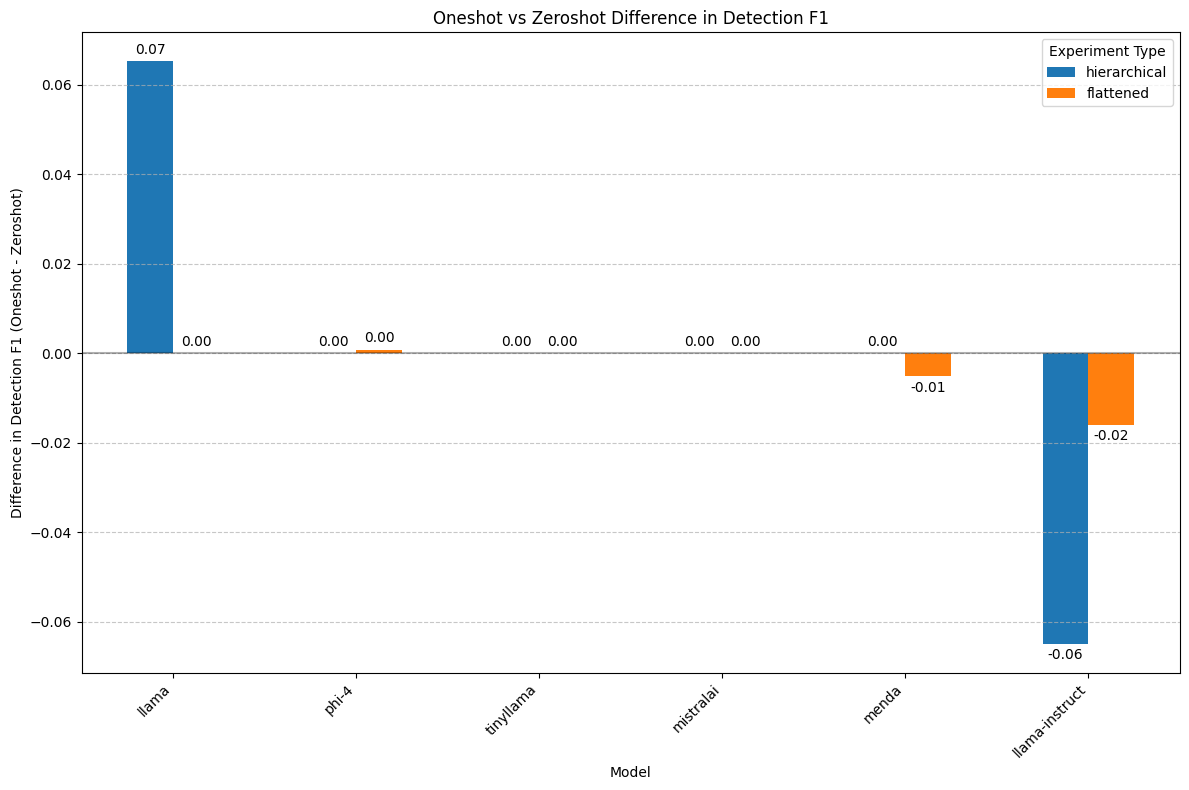

<Figure size 1200x800 with 0 Axes>

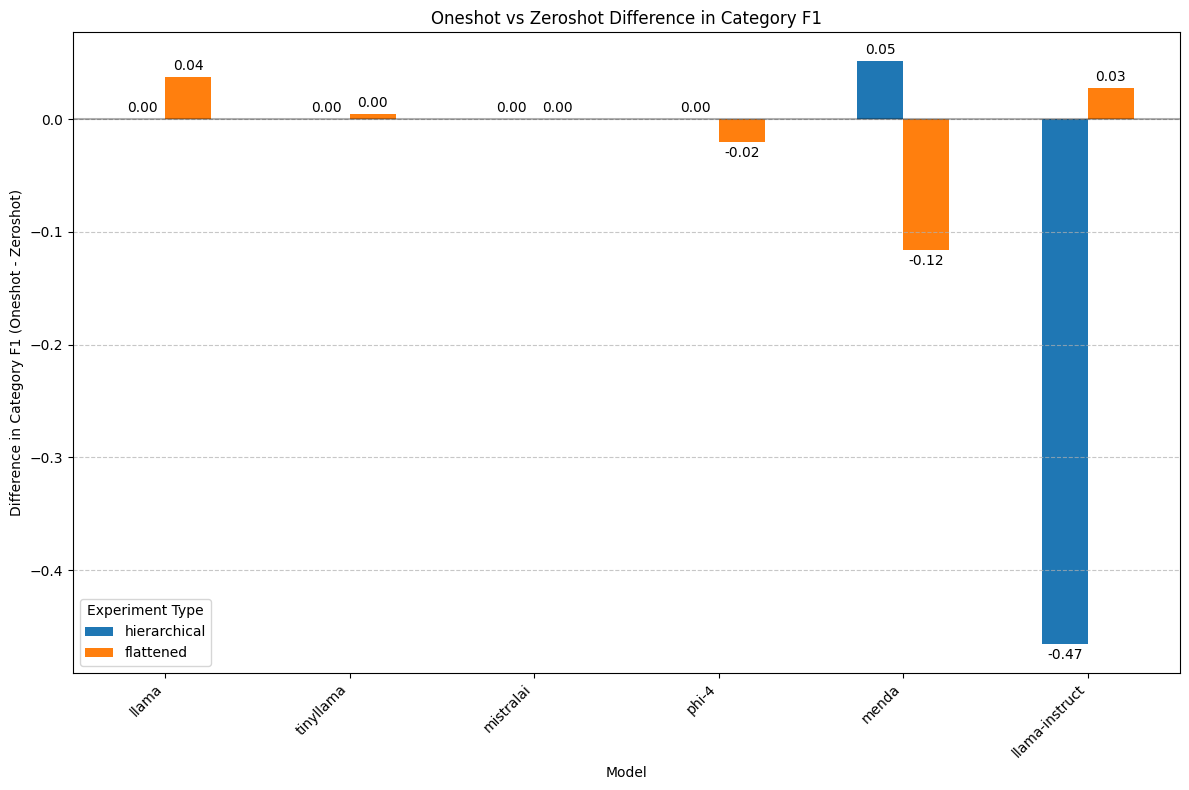

<Figure size 1200x800 with 0 Axes>

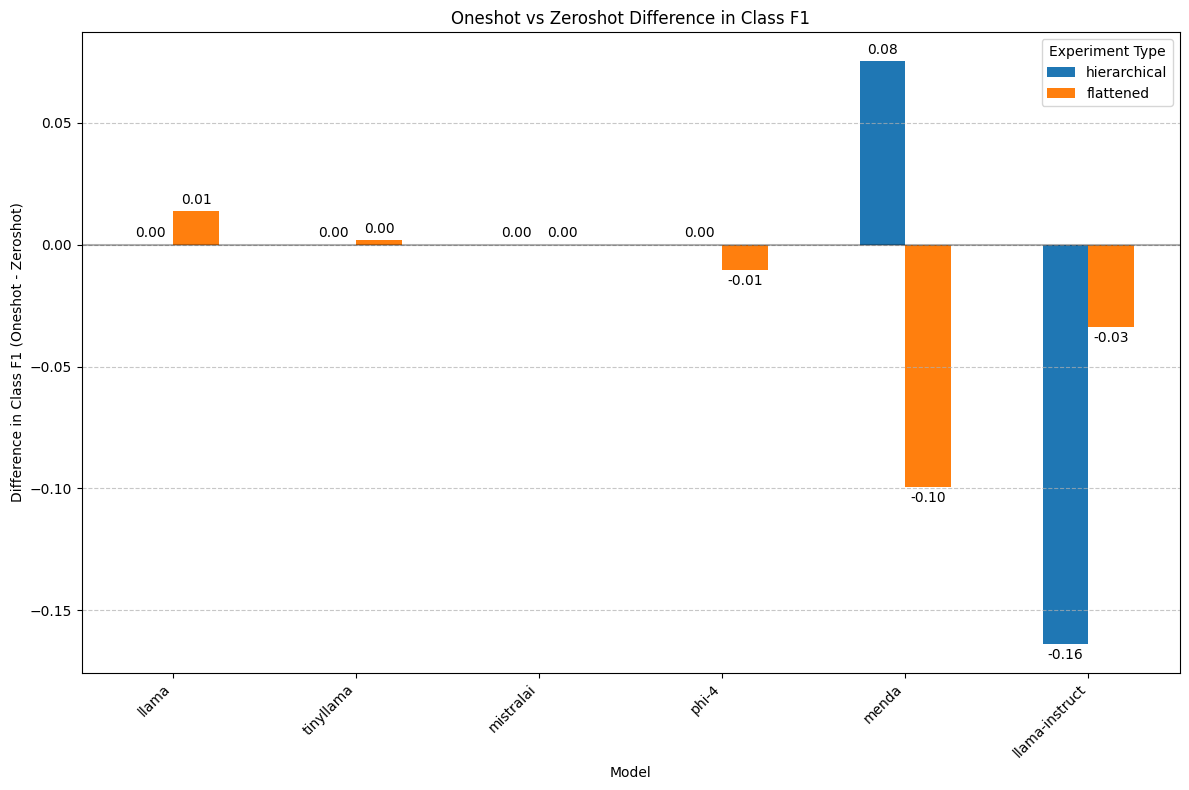

In [13]:
def plot_shot_difference(all_experiments, experiment_names, metric, title=None, figsize=(12, 8)):
    """
    Plot the difference between zeroshot and oneshot versions of experiments for a given metric
    
    Parameters:
    all_experiments (dict): Dictionary of experiment results
    experiment_names (list): List of experiment base names (without 'oneshot_' or 'zeroshot_' prefix)
    metric (str): The metric to compare (e.g., 'detection_f1')
    title (str, optional): Title for the plot
    figsize (tuple, optional): Figure size
    
    Returns:
    matplotlib.pyplot: The plot object
    """
    # Create a dictionary to store the differences
    difference_data = {}
    
    # For each experiment base name, find the oneshot and zeroshot versions
    for base_name in experiment_names:
        oneshot_name = f"oneshot_{base_name}"
        zeroshot_name = f"zeroshot_{base_name}"
        
        # Check if both versions exist
        if oneshot_name in all_experiments and zeroshot_name in all_experiments:
            # Get the oneshot data
            oneshot_data = {}
            for df in all_experiments[oneshot_name]:
                model_name = df['model_name'].values[0]
                if metric in df.columns:
                    oneshot_data[model_name] = df[metric].values[0]
            
            # Get the zeroshot data
            zeroshot_data = {}
            for df in all_experiments[zeroshot_name]:
                model_name = df['model_name'].values[0]
                if metric in df.columns:
                    zeroshot_data[model_name] = df[metric].values[0]
            
            # Calculate differences for models that appear in both
            for model in set(oneshot_data.keys()).intersection(set(zeroshot_data.keys())):
                if model not in difference_data:
                    difference_data[model] = {}
                
                # Calculate oneshot - zeroshot difference
                difference_data[model][base_name] = oneshot_data[model] - zeroshot_data[model]
    
    # Convert to DataFrame
    diff_df = pd.DataFrame.from_dict(difference_data, orient='index')
    
    # Sort by the sum of differences to get a reasonable order
    if not diff_df.empty:
        diff_df['sum'] = diff_df.sum(axis=1)
        diff_df = diff_df.sort_values(by='sum', ascending=False)
        diff_df = diff_df.drop('sum', axis=1)
    
    # Create plot
    plt.figure(figsize=figsize)
    ax = diff_df.plot(kind='bar', figsize=figsize)
    
    # Add a horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel(f'Difference in {metric.replace("_", " ").title()} (Oneshot - Zeroshot)')
    
    if title:
        plt.title(title)
    else:
        plt.title(f'Difference Between Oneshot and Zeroshot for {metric.replace("_", " ").title()}')
    
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Experiment Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)
    
    plt.tight_layout()
    return plt

# Example usage:
metric_to_compare = 'detection_f1'
experiment_bases = ['hierarchical', 'flattened', 'fixed'] 

# loop through all metrics and plot the differences
metrics_to_compare = ['detection_f1', 'category_f1', 'class_f1']
for metric in metrics_to_compare:
    plot_shot_difference(
        all_experiments, 
        experiment_bases, 
        metric, 
        title=f"Oneshot vs Zeroshot Difference in {metric.replace('_', ' ').title()}"
    )
    plt.show()

In [14]:
def plot_experiment_difference(all_experiments, experiment1, experiment2, metric, shot_types=None, 
                              title=None, figsize=(12, 8), use_colors=True):
    """
    Plot the difference between two experiment types for a given metric and shot types
    
    Parameters:
    all_experiments (dict): Dictionary of experiment results
    experiment1 (str): Base name of the first experiment (without 'oneshot_' or 'zeroshot_' prefix)
    experiment2 (str): Base name of the second experiment (without 'oneshot_' or 'zeroshot_' prefix)
    metric (str): The metric to compare (e.g., 'detection_f1')
    shot_types (list, optional): List of shot types to include ('oneshot', 'zeroshot'). 
                                If None, includes both.
    title (str, optional): Title for the plot
    figsize (tuple, optional): Figure size
    use_colors (bool, optional): Whether to use custom colors for the shot types
    
    Returns:
    matplotlib.pyplot: The plot object
    """
    # Set default shot types if None
    if shot_types is None:
        shot_types = ['oneshot', 'zeroshot']
    elif isinstance(shot_types, str):
        shot_types = [shot_types]  # Convert single string to list
    
    # Create a dictionary to store the differences
    difference_data = {}
    
    # For each shot type, find the experiment versions
    for shot_type in shot_types:
        exp1_name = f"{shot_type}_{experiment1}"
        exp2_name = f"{shot_type}_{experiment2}"
        
        # Check if both experiment versions exist
        if exp1_name in all_experiments and exp2_name in all_experiments:
            # Get the first experiment data
            exp1_data = {}
            for df in all_experiments[exp1_name]:
                model_name = df['model_name'].values[0]
                if metric in df.columns:
                    exp1_data[model_name] = df[metric].values[0]
            
            # Get the second experiment data
            exp2_data = {}
            for df in all_experiments[exp2_name]:
                model_name = df['model_name'].values[0]
                if metric in df.columns:
                    exp2_data[model_name] = df[metric].values[0]
            
            # Calculate differences for models that appear in both
            for model in set(exp1_data.keys()).intersection(set(exp2_data.keys())):
                if model not in difference_data:
                    difference_data[model] = {}
                
                # Calculate exp1 - exp2 difference
                difference_data[model][shot_type] = exp1_data[model] - exp2_data[model]
    
    # Convert to DataFrame
    diff_df = pd.DataFrame.from_dict(difference_data, orient='index')
    
    # Sort by the sum of differences to get a reasonable order
    if not diff_df.empty:
        diff_df['sum'] = diff_df.sum(axis=1)
        diff_df = diff_df.sort_values(by='sum', ascending=False)
        diff_df = diff_df.drop('sum', axis=1)
    
    # Create plot with custom colors if requested
    plt.figure(figsize=figsize)
    if use_colors and len(shot_types) > 1:
        colors = {'oneshot': '#1f77b4', 'zeroshot': '#ff7f0e'}  # Blue for oneshot, orange for zeroshot
        selected_colors = [colors.get(shot, '#2ca02c') for shot in diff_df.columns]
        ax = diff_df.plot(kind='bar', figsize=figsize, color=selected_colors)
    else:
        ax = diff_df.plot(kind='bar', figsize=figsize)
    
    # Add a horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel(f'Difference in {metric.replace("_", " ").title()} ({experiment1} - {experiment2})')
    
    if title:
        plt.title(title)
    else:
        plt.title(f'Difference Between {experiment1} and {experiment2} for {metric.replace("_", " ").title()}')
    
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Shot Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)
    
    plt.tight_layout()
    return plt

# Example usage:
# Compare hierarchical vs flattened for both oneshot and zeroshot
metric_to_compare = 'detection_f1'

plot_experiment_difference(
    all_experiments, 
    'fixed', 
    'flattened',
    metric_to_compare, 
    shot_types=['oneshot', 'zeroshot'],
    title=f"Hierarchical vs Flattened Difference in {metric_to_compare.replace('_', ' ').title()}"
)
plt.show()

plot_experiment_difference(
    all_experiments, 
    'hierarchical', 
    'flattened',
    metric_to_compare, 
    shot_types=['oneshot', 'zeroshot'],
    title=f"Hierarchical vs Flattened Difference in {metric_to_compare.replace('_', ' ').title()}"
)
plt.show()

plot_experiment_difference(
    all_experiments, 
    'hierarchical', 
    'fixed',
    metric_to_compare, 
    shot_types=['oneshot', 'zeroshot'],
    title=f"Hierarchical vs Flattened Difference in {metric_to_compare.replace('_', ' ').title()}"
)
plt.show()

TypeError: no numeric data to plot

<Figure size 1200x800 with 0 Axes>